# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series, Timedelta
from scipy.ndimage import binary_dilation
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
RAW_DATA_PATH = "../raw_data/"
ADDITIONAL_DATA_PATH = "../additional_data/"

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

In [ ]:
processed_dfs.keys()

dict_keys(['train', 'gas_prices', 'client', 'electricity_prices', 'forecast_weather', 'historical_weather', 'station_county_mapping', 'county_id_to_name_map', 'holidays'])

In [ ]:
df = merge_all_dfs(processed_dfs, how="left")

In [ ]:
df = add_dst_flag(df)

In [ ]:
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
# for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            window=window,
        ).dropna(),
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
# w, h = 20, 14

# fig, ax = plt.subplots(figsize=(w, h))
# # plt.figure(figsize=(w, h))

# sns.heatmap(
#     df.drop(
#         columns=df.select_dtypes(["category"]).columns.tolist()
#         + [
#             "datetime",
#             "data_block_id",
#             "date",
#         ]
#     ).corr(),
#     annot=True,
#     fmt=".1f",
#     annot_kws={"size": 7},
# )


# buf = io.BytesIO()
# fig.savefig(buf, format="png", bbox_inches="tight")
# buf.seek(0)
# img_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

# html_code = (
#     '<div style="overflow-x: auto; width: 100%;">'
#     '<img src="data:image/png;base64,{}" style="display: block; max-width: none; width: auto;">'
#     "</div>"
# ).format(img_base64)

# display(HTML(html_code))
# plt.close(fig)
# # plt.show()

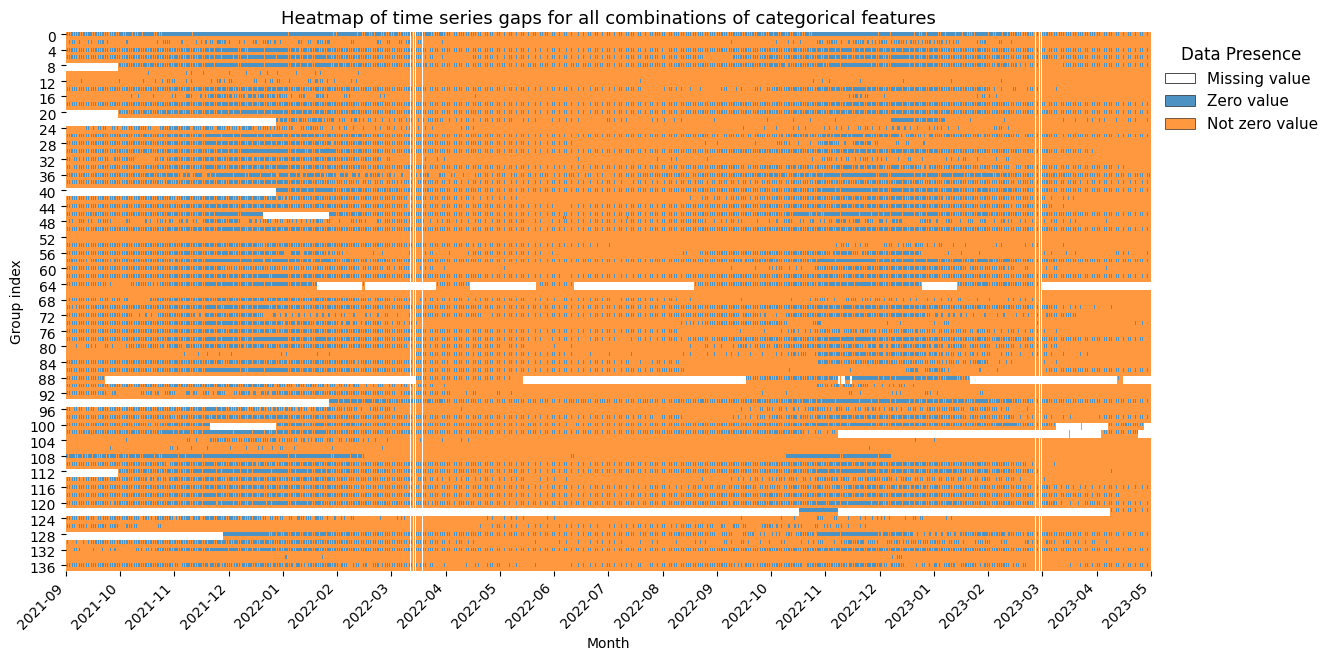

In [ ]:
df_for_missing = df[TARGET_C + ["target"]].dropna().copy()

# Add hour index starting from the beginning
df_for_missing["hour_index"] = (
    (df_for_missing["datetime"] - df_for_missing["datetime"].min())
    // pd.Timedelta(hours=1)
).astype(np.uint16)


# Add a group index corresponding to the unique combination of all
# categorical features (i.e. this feature is not equal to
# prediction_unit_id): county, is_business, product_type,
# is_consumption.
# The maximum number of combinations is 16 * 4 * 2 * 2 = 256, but the
# actual number of observed values is less than 256
df_for_missing["group_index"] = (
    df_for_missing.groupby(
        CATEGORICAL_C,
        observed=True,
    )
    .ngroup()
    .astype(np.uint8)
)

# Create a 2D array with a shape equal to the number of groups and the
# total number of hours between the minimum and maximum timestamps
n_groups = df_for_missing["group_index"].nunique()
n_hours = df_for_missing["hour_index"].max() + 1
missmap = np.full((n_groups, n_hours), np.nan)

# Fill the array with the corresponding flag values
missmap[df_for_missing["group_index"], df_for_missing["hour_index"]] = (
    df_for_missing["target"] != 0
)

# Dilate missing values because of high density of plot and isolated
# missing values are not visible.
n = 6  # How many hours before and after count as missing
structure = np.ones((1, 2 * n + 1), dtype=bool)
missing_dilated = binary_dilation(np.isnan(missmap), structure=structure)
missmap[missing_dilated] = np.nan

alpha = 0.8

min_date = df_for_missing["datetime"].min()
max_date = df_for_missing["datetime"].max()
n_months = len(pd.date_range(start=min_date, end=max_date, freq="ME"))


fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(
    missmap,
    cmap=sns.color_palette(["tab:blue", "tab:orange"]),
    cbar=False,
    alpha=alpha,
    ax=ax,
)

xtick_indices = np.linspace(0, n_hours, num=n_months, dtype=int)
xtick_labels = pd.date_range(min_date, max_date, freq="ME")


ax.set_xticks(xtick_indices)
ax.set_xticklabels(xtick_labels.strftime("%Y-%m"), rotation=45, ha="right")

dx, dy = 0, -2.5
for label in ax.get_yticklabels():
    offset = mt.ScaledTranslation(dx / 72, dy / 72, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)

legend_patches = [
    mpatches.Patch(
        facecolor="white",
        label="Missing value",
        edgecolor="black",
        linewidth=0.5,
    ),
    mpatches.Patch(
        facecolor="tab:blue",
        alpha=alpha,
        label="Zero value",
        edgecolor="black",
        linewidth=0.5,
    ),
    mpatches.Patch(
        facecolor="tab:orange",
        alpha=alpha,
        label="Not zero value",
        edgecolor="black",
        linewidth=0.5,
    ),
]

plt.legend(
    handles=legend_patches,
    title="Data Presence",
    title_fontsize=12,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    fontsize=11,
    frameon=False,
)

plt.title(
    "Heatmap of time series gaps for all combinations "
    "of categorical features",
    fontsize=13,
)
plt.xlabel("Month", fontsize=10)
plt.ylabel("Group index", fontsize=10)
plt.grid(False)
plt.show()

# 3. Simple Baseline

## xgb with splits

In [ ]:
def split_by_equal_days(
    dt: Series,
    train_days: int = 1,
    fh_days: int = 1, # Only daily predictions as per problem statement
    val_splits: int = 1,
    expanding: bool = True,
) -> list[dict[str, tuple[pd.Timestamp, pd.Timestamp]]]:
    dt = dt.dt.floor("D") # Processing on a day scope

    train_days = Timedelta(days=train_days)
    train_days_delta = train_days - Timedelta(days=1)  # Indexing from 0


    fh_days = Timedelta(days=fh_days)
    fh_days_delta = fh_days - Timedelta(days=1)  # Indexing from 0

    first_day = dt.min()
    last_day = dt.max()

    # test_start = last_day - fh_days_delta
    # test_end = last_day + pd.Timedelta(hours=23)

    splits = []

    intermediate_period_start = first_day + train_days
    intermediate_period_end = last_day - fh_days
    intermediate_period_days = (intermediate_period_end - intermediate_period_start).days
    base_step = Timedelta(days=intermediate_period_days // val_splits)
    step_rem = Timedelta(days=intermediate_period_days % val_splits)
    
    for step in range(val_splits):
        offset = base_step * step + min(Timedelta(days=step), step_rem)
        if expanding:
            train_start = first_day
            train_end = train_start + train_days_delta + offset + pd.Timedelta(hours=23)
        else:
            train_start = first_day + offset
            train_end = train_start + train_days_delta + pd.Timedelta(hours=23)

        val_start = train_end + pd.Timedelta(hours=1)
        val_end = val_start + fh_days_delta + pd.Timedelta(hours=23)
        splits.append(
            {
                "train": (train_start, train_end),
                "val": (val_start, val_end),
                # "test": (test_start, test_end),
            }
        )

    return splits

In [ ]:
print(
    f"First timestamp: {df["datetime"].min()}",
    f"Last timestamp: {df["datetime"].max()}",
    sep="\n"
)

Since the minimum usable lag for prediction is 48 hours, this horizon is particularly well suited as a naive baseline.

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

In [ ]:
val_splits = 10

In [ ]:
test_start = df["datetime"].max().normalize()
df_test = df.loc[df["datetime"] >= test_start].drop(FEATURES_TO_DROP, axis=1)

In [ ]:
splits_expanding = split_by_equal_days(
    dt=df["datetime"],
    train_days=365,
    fh_days=30,
    val_splits=val_splits,
    expanding=True,
)
splits_fixed = split_by_equal_days(
    dt=df["datetime"],
    train_days=365,
    fh_days=2,
    val_splits=val_splits,
    expanding=False,
)

In [ ]:
val_mae_2dlag = []

for split in range(val_splits):
    val_df = df.loc[
        (df["datetime"] >= splits_expanding[split]["val"][0])
        & (df["datetime"] <= splits_expanding[split]["val"][1]),
        ["target", "2d_lag_target"],
    ]
    val_mae_2dlag.append(MAE(val_df["target"], val_df["2d_lag_target"]))
else:
    test_df = df.loc[df["datetime"] >= test_start]
    val_mae_2dlag.append(MAE(test_df["target"], test_df["2d_lag_target"]))

print("Validation MAE:", np.round(val_mae_2dlag, 3))
print("Validation mean MAE:", np.round(np.mean(val_mae_2dlag), 3))

In [ ]:
# df["datetime"].is_monotonic_increasing
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
splits_fixed = split_by_equal_days(
    dt=df["datetime"],
    train_days=365,
    fh_days=3,
    val_splits=5,
    expanding=False,
)

In [ ]:
xgbr_p = {
    "n_estimators": 1000,
    "max_depth": 5,
    "early_stopping_rounds": 100,
    "eval_metric": "mae",
    "learning_rate": 0.1,
    "random_state": RAND,
    "verbosity": 1,
    "enable_categorical": True,
}

MAE_xgbr = []

# for split in splits_expanding:
for i, split in enumerate(splits_fixed):
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)
    df_val = df[
        (df["datetime"] >= split["val"][0])
        & (df["datetime"] <= split["val"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
    X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
    X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

    eval_set = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

    print(f"{i+1} split")
    print("-" * 20)
    print("train")
    print("start:", split["train"][0])
    print("end:", split["train"][1])
    print("shape:", X_train.shape, y_train.shape)
    print("-" * 20)
    print("val")
    print("start:", split["val"][0])
    print("end:", split["val"][1])
    print("shape:", X_val.shape, y_val.shape)

    xgbr = XGBRegressor(**xgbr_p)
    xgbr.fit(X_train, y_train, eval_set=eval_set)
    y_pred = xgbr.predict(X_test)
    MAE_xgbr.append(
        {
            "train_mae": xgbr.evals_result()["validation_0"]["mae"],
            "val_mae": xgbr.evals_result()["validation_1"]["mae"],
            "test_mae": xgbr.evals_result()["validation_2"]["mae"],
        },
    )

In [ ]:
# MAE_xgbr

In [ ]:
plt.figure(figsize=(15, 12))

for i, d in enumerate(MAE_xgbr):
    plt.plot(d["train_mae"], label=f"{i+1} split train")
    plt.plot(d["val_mae"], label=f"{i+1} split val")
    plt.plot(d["test_mae"], label=f"{i+1} split test")

plt.xlabel("Number of estimators")
plt.ylabel("MAE")

plt.legend()
# plt.yscale("log")
plt.grid(which='both')
plt.show()

In [ ]:
qwe

In [ ]:
df.shape[0]*.8

In [ ]:
MAE_xgbr[0][2]

In [ ]:
df_train = df[df["datetime"] < train_ts].drop(FEATURES_TO_DROP, axis=1)
df_val = df[
    (df["datetime"] >= train_ts) & (df["datetime"] < val_ts)
].drop(FEATURES_TO_DROP, axis=1)
df_test = df[
    (df["datetime"] >= val_ts) & (df["datetime"] < test_ts)
].drop(FEATURES_TO_DROP, axis=1)

X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
# example_df = df.loc[df["datetime"] < test_timestamp]

In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

params = {
    "boosting_type": "dart",
    "n_estimators": 1000,
    "max_depth": 5,
    # "early_stopping_rounds": 100,
    "metric": "mae",
    "learning_rate": 0.1,
    "random_state": RAND,
    "verbose": 1
}

In [ ]:
lgbmr = LGBMRegressor( **params)

In [ ]:
lgbmr.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    callbacks=[
        early_stopping(stopping_rounds=100, verbose=True),
        log_evaluation(period=20),
    ],
)

In [ ]:
results = lgbmr.evals_result_

plt.plot(results["training"]["l1"], label="Training loss")
plt.plot(results["valid_1"]["l1"], label="Validation loss")

plt.xlabel("Number of estimators")
plt.ylabel("Loss")

plt.legend()
# plt.yscale("log")
plt.grid(which='both')

plt.show()

In [ ]:
xgbr = XGBRegressor(**params, enable_categorical=True)
lgbmr = LGBMRegressor(**params)
cbr = CatBoostRegressor(**params)

MAE_xgbr = []
MAE_lgbmr = []
MAE_cbr = []

In [ ]:
df_test = df[
    (df["datetime"] >= splits_expanding[0]["test"][0])
    & (df["datetime"] <= splits_expanding[0]["test"][1])
].drop(FEATURES_TO_DROP, axis=1)

In [ ]:
for split in splits_expanding:
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)
    df_val = df[
        (df["datetime"] >= split["val"][0])
        & (df["datetime"] <= split["val"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
    X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
    X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgbr.fit(X_train, y_train, eval_set=eval_set, verbose=True)
    y_pred = xgbr.predict(X_test)
    MAE_xgbr.append(
        ({
            "val_mae": xgbr.evals_result()["validation_0"]["mae"],
            "test_mae": np.mean(MAE(y_test, y_pred), 3),}
        )
    )
-------------
    lgbmr.fit(X_train, y_train, eval_set=eval_set, verbose=True)
    y_pred = lgbmr.predict(X_test)
    MAE_lgbmr.append(
        (
            {"val_mae": lgbmr.evals_result_["valid_1"]["mae"],
            np.mean(MAE(y_test, y_pred), 3),
        )
    )

    cbr.fit(X_train, y_train, eval_set=eval_set, verbose=True)
    y_pred = cbr.predict(X_test)
    MAE_cbr.append(
        (
            cbr.evals_result()["validation_0"]["mae"],
            np.mean(MAE(y_test, y_pred), 3),
        )
    )

In [ ]:
xgbr.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True
)

In [ ]:
y_pred = xgbr.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
results = xgbr.evals_result()

plt.plot(results["validation_0"]["mae"], label="Training loss")
plt.plot(results["validation_1"]["mae"], label="Validation loss")

plt.xlabel("Number of estimators")
plt.ylabel("Loss")

plt.legend()
# plt.yscale("log")
plt.grid(which='both')

plt.show()

In [ ]:
# df_train = df[df["datetime"] < train_ts].drop(FEATURES_TO_DROP, axis=1)
# df_val = df[
#     (df["datetime"] >= train_ts) & (df["datetime"] < val_ts)
# ].drop(FEATURES_TO_DROP, axis=1)
# df_test = df[
#     (df["datetime"] >= val_ts) & (df["datetime"] < test_ts)
# ].drop(FEATURES_TO_DROP, axis=1)

# X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
# X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
# X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

In [ ]:
# eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

In [ ]:
fi = pd.Series(xgbr.feature_importances_, index=X_train.columns)
fi = fi.sort_values(ascending=False).head(20)

fi.plot.barh(figsize=(8,6))
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.show()